In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd

import random as python_random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

In [8]:
def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
def get_preprocessed_data(images, labels, scaling=True):
    if scaling:
        images = np.array(images/255.0, dtype=np.float32)
    else:
        images = np.array(images, dtype=np.float32)
    
    labels = np.array(labels, dtype=np.float32)
    
    return images, labels

def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels, scaling=False)
    oh_labels = to_categorical(labels)
    return images, oh_labels

def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)

set_random_seed(2021)
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021)
print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


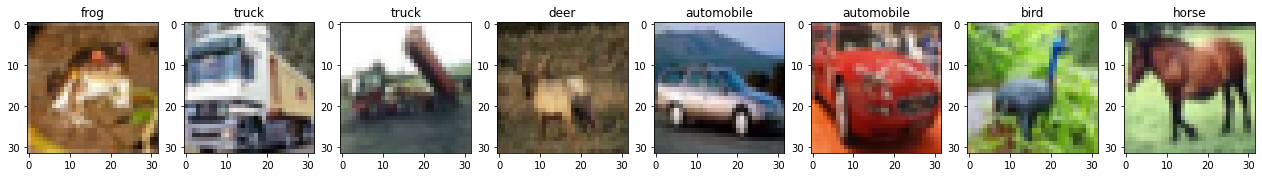

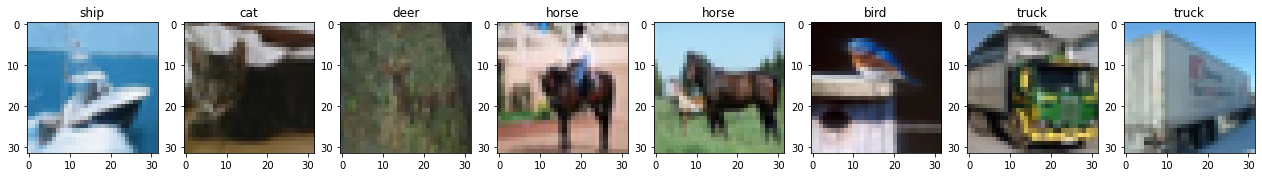

In [15]:
import matplotlib.pyplot as plt
import cv2

NAMES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i])
        label = labels[i].squeeze()
        axs[i].set_title(NAMES[int(label)])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

In [16]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

### ImageDataGenerator로 Augmentation 설정하고 학습용, 검증용 Generrator 생성

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
#     rotaion_range=20,
#     zoom_range=(0.7, 0.9),
    horizontal_flip=True,
#     vertical_flip=True,
    rescale=1/255.0
)
valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

### Keras CNN 모델 생성

In [23]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

def create_model(verbose=False):
    input_shape = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = Conv2D(filters=64, kernel_size=3, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(2)(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_shape, outputs=output)
    if verbose:
        model.summary()
        
    return model

In [21]:
model = create_model(verbose=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                           

In [24]:
image_batch, label_batch = next(flow_tr_gen)
print(image_batch.shape, label_batch.shape)
print(image_batch[0])

(64, 32, 32, 3) (64, 10)
[[[0.9921569  0.9921569  0.9921569 ]
  [0.9921569  0.9921569  0.9921569 ]
  [0.98823535 0.98823535 0.98823535]
  ...
  [0.98823535 0.98823535 0.98823535]
  [0.98823535 0.98823535 0.98823535]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         0.9960785  1.        ]
  ...
  [1.         0.9960785  0.9960785 ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         0.9960785  1.        ]
  ...
  [1.         0.9960785  0.9960785 ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 ...

 [[1.         1.         1.        ]
  [1.         1.         1.        ]
  [1.         1.         0.9960785 ]
  ...
  [1.         1.         0.9960785 ]
  [1.         1.         1.        ]
  [1.         1.         1.        ]]

 [[1.         1.         1.        ]
  [1.       

In [31]:
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]
history = model.fit(flow_tr_gen, epochs=40, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                    validation_data=flow_val_gen, 
                    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb])

Epoch 1/40
665/665 [==============================] - 16s 24ms/step - loss: 0.9943 - accuracy: 0.6543 - val_loss: 0.8978 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 16s 23ms/step - loss: 0.8120 - accuracy: 0.7204 - val_loss: 1.0096 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 16s 24ms/step - loss: 0.6895 - accuracy: 0.7676 - val_loss: 0.9530 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 15s 23ms/step - loss: 0.6032 - accuracy: 0.7964 - val_loss: 0.7518 - val_accuracy: 0.7553 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 16s 24ms/step - loss: 0.5383 - accuracy: 0.8197 - val_loss: 0.5753 - val_accuracy: 0.8076 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 16s 24ms/step - loss: 0.4896 - accuracy: 0.8370 - val_loss: 0.9431 - val_accuracy: 0.7076 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 16s 

In [32]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 1s 9ms/step - loss: 0.4243 - accuracy: 0.8861


[0.42433324456214905, 0.8860999941825867]

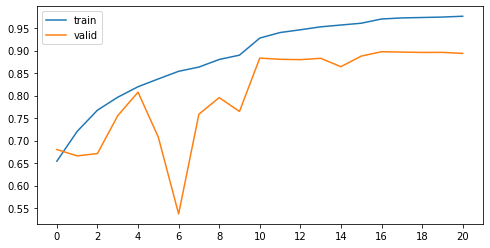

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.figure(figsize=(8, 4))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.xticks(np.arange(0, 30, 2))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    
show_history(history)

### 원본 이미지 상황에 맞지 않거나 과도한 Augmentation은 오히려 성능을 저하시킴.

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rotation_range=20,
    zoom_range=(0.7, 0.9),
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255.0
)

valid_generator = ImageDataGenerator(rescale=1/255.0)

flow_tr_gen = train_generator.flow(tr_images, tr_oh_labels, batch_size=BATCH_SIZE, shuffle=True)
flow_val_gen = valid_generator.flow(val_images, val_oh_labels, batch_size=BATCH_SIZE, shuffle=False)

model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 5번 iteration내에 validation loss가 향상되지 않으면 learning rate을 기존 learning rate * 0.2로 줄임.  
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
# 10번 iteration내에 validation loss가 향상되지 않으면 더 이상 학습하지 않고 종료
ely_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)

# steps 횟수를 구하기 위해 학습 데이터의 건수와 검증 데이터의 건수를 구함. steps = ceil(학습 데이터 건수/BATCH_SIZE)
tr_data_len = tr_images.shape[0]
val_data_len = val_images.shape[0]

history = model.fit(flow_tr_gen, epochs=40, 
                    steps_per_epoch=int(np.ceil(tr_data_len/BATCH_SIZE)),
                    validation_data=flow_val_gen, 
                    validation_steps=int(np.ceil(val_data_len/BATCH_SIZE)),
                    callbacks=[rlr_cb, ely_cb], verbose=1)


Epoch 1/40
665/665 [==============================] - 18s 25ms/step - loss: 1.7597 - accuracy: 0.3484 - val_loss: 2.1635 - val_accuracy: 0.2835 - lr: 0.0010
Epoch 2/40
665/665 [==============================] - 16s 25ms/step - loss: 1.4392 - accuracy: 0.4789 - val_loss: 1.5569 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 3/40
665/665 [==============================] - 16s 24ms/step - loss: 1.2711 - accuracy: 0.5458 - val_loss: 1.3952 - val_accuracy: 0.5176 - lr: 0.0010
Epoch 4/40
665/665 [==============================] - 16s 24ms/step - loss: 1.1502 - accuracy: 0.5925 - val_loss: 1.5684 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 5/40
665/665 [==============================] - 16s 24ms/step - loss: 1.0666 - accuracy: 0.6234 - val_loss: 1.1383 - val_accuracy: 0.5999 - lr: 0.0010
Epoch 6/40
665/665 [==============================] - 16s 24ms/step - loss: 0.9934 - accuracy: 0.6508 - val_loss: 3.6144 - val_accuracy: 0.2911 - lr: 0.0010
Epoch 7/40
665/665 [==============================] - 16s 

In [36]:
test_generator = ImageDataGenerator(rescale=1/255.0)
flow_test_gen = test_generator.flow(test_images, test_oh_labels, batch_size=BATCH_SIZE, shuffle=False)
model.evaluate(flow_test_gen)

157/157 [==============================] - 2s 9ms/step - loss: 0.6112 - accuracy: 0.8018


[0.6111753582954407, 0.801800012588501]